# Manifold Learning

We've seen how PCA can be used in the dimensionality reduction task. While PCA is flexible, fast and easily interpretable, it does not perform so well when there are _nonlinear_ relationships within the data.

To address this deficiency, we can use a class of methods known as _manifold learning_: a class unsupervised methods that seeks to describe datasets as low-dimensional manifold embedded in high-dimensional spaces. A manifold can be thought of as a sheet of paper: a two-dimensional object that lives in our three-dimensional world, and can be bent or rolled in that two dimensions. In the parlance of manifold learning, this sheets would be a two-dimensional manifold embedded din three-dimensional space.

Rotating, re-orientating, or stretching the piece of paper doesn't change its flat geometry: such operations are akin linear embeddings. After bending or curling the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear. Manifold algorithms would seek to learn about the fundamental two-dimensional nature of the paper.

In this section we'll take a look at some manifold methods, exploring deeper a couple techniques: multidimensional scaling (MDS), locally linear embedding (LLE), and isometric mapping (IsoMap).

We begin with the standard imports as usual:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Manifold Learning: "HELLO" 

Let's make these concepts more clear by generating some two-dimensional data that we can use to define a manifold. The following function creates data in the shape of the word "HELLO":

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

Let's call the function and visualize the data that will help us see visually what these manifolds algorithms are doing:

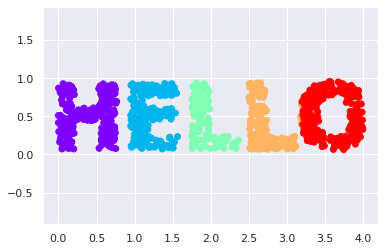

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

## Multidimensional Scaling (MDS)

We can see that the particular choice of $x$ and $y$ values are not exactly what describes the data: even after scaling, shrinking, or rotating the data, the word "HELLO" will still be apparent. We can see this by using a rotation matrix to rotate the data, which changes the $x$ and $y$ values, while the data fundamentally remains the same:

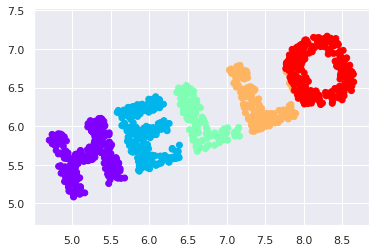

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

Although the $x$ and $y$ values are not fundamental to the relationships in the data, the _distance_ between each point and the other points in the dataset _is_! We can represent this with a distance matrix, which can be computed using `pairwise_distances`:

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

For our $N=1000$ points, we obtain a 1000$\times$1000 matrix, which can be visualized below:

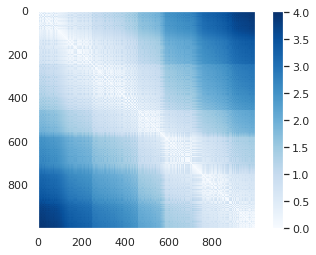

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

We can construct a distance matrix for our rotated data, and verify that its still the same:

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

This distance matrix gives us a representation of the data that is invariant to rotations and translations, but we've lost the intuitive visualization in this process.

The multidimensional scaling algorithm proves useful here: given a distance matrix between points, it recovers a $D$-dimensional coordinate representation of the data. Let's see how it works four our distance matrix:

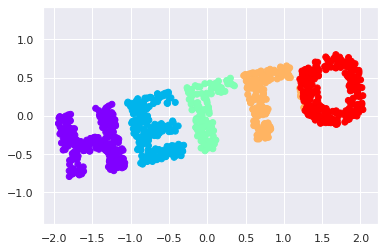

In [8]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

The MDS recovered one of the possible two-dimensional coordinate representations of our data, using _only_ the distance matrix describing the relationship between the data points.

## MDS as Manifold Learning

The usefulness of this comes from the fact that distance matrices can be computed from data in _any_ dimension. For example, let's project our data into three-dimensions using the following function:

In [9]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

This is what our data looks like after the transform:

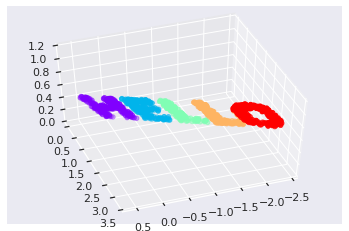

In [10]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

We can now use the `MDS` estimator to determine the optimal two-dimensional embedding for this distance matrix. The result recovers a representation of the original data:

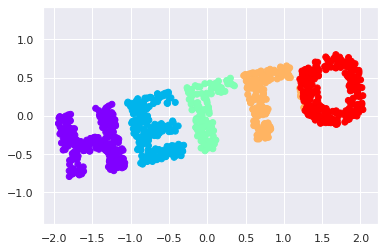

In [11]:
model = MDS(n_components=2, random_state=0)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

This sums up the goal of a manifold learning estimator: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data. MDS is a method that preserves the distance between every pair of points.

## Nonlinear Embeddings: Where MDS Fails

So far we've only considered linear embeddings, which consits of rotations, translations and scalings of data into higher-dimensional spaces. Where MDS fails is when the embedding is nonlinear. Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

In [12]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

This is still three-dimensional data, but the embedding is clearly much more complicated:

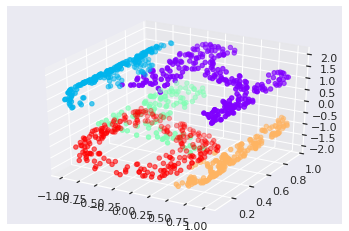

In [13]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);

A simple MDS algorithm is not able to "unwrap" this nonlinear embedding:

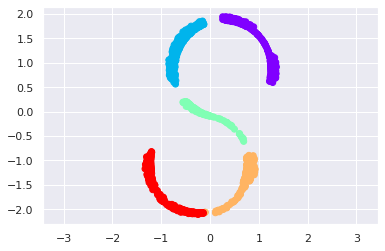

In [14]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

The best two-dimensional _linear_ embedding just throws out the original y-axis, instead of unwrapping the S curve.

# Nonlinear Manifolds: Locally Linear Embedding

We can see that the source of the problem is that MDS tries to preserve distance between faraway points while constructing the embedding. If we modified the algorithm such that it only preserves distances between nearby points, the resulting embedding would be closer to what we want.

We can think of it as illustrated in this figure:

![MDS x LLE](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.10-LLE-vs-MDS.png)

In this image, each line represents a distance that should be preserved in the embedding. The model used by MDS (on the left) tries to preserve the distances between each pair of points in the dataset. On the right we have a representation of the model used by a manifold algorithm called locally linear embedding (LLE): the difference is that it instead tries to preserve only the distances between _neighbor points_: in this case, the nearest 100 neighbors of each point.

LLE comes in a number of different flavors. Here we will use the _modified LLE_ algorithm to recover the embedded two-dimensional manifold. In general, modified LLE does better than other flavors at recovering well-defined manifolds with very little distortion:

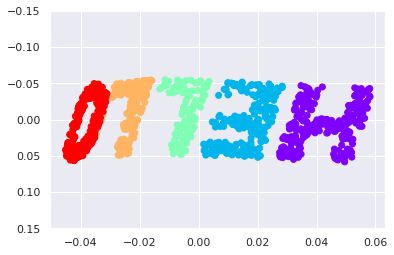

In [15]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

The result remains distorted compared to the original data, but it still captures the essential relationships in the data.

# Some Thoughts on Manifold Methods

Despite the compelling motivation, manifold learning techniques tend to be rarely used in practice for anything more than simple qualitative visualization of high-dimensional data.

The following are some of the particular challenges of manifold learning:

- In manifold learning, there is no good framework for handling missing data.
- The presence of noise can drastically change the embedding, while PCA naturally filters noise from the most important components.
- The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is no solid quantitative way to choose this parameter.
- The globally optimal number of output dimensions is much more difficult to determine, while PCA lets we find the output dimensions based on the explained variance.
- The meaning of the embedded dimensions is not always clear.
- Computational expense of manifold methods are usually of the order of $\mathcal{O}(N^2)$ or $\mathcal{O}(N^3)$. which can grow to be intractable very quickly.

Considering all of this, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data. 

The author gives some insightful recommendations based on personal experience:

- LLE and its variants (especially _modified LLE) tends to perform very well for toy problems such as the S-curve we saw previously.
- For high-dimensional data from the real-world, LLE often produces poor results, and isometric mapping (IsoMap) seems to perform generally better, producing more meaningful embeddings.
- For data that is highly clustered, _t-distributed stochastic neighbor embedding_ (t-SNE) seems to work very well.

# Example: Isomap on Faces

Manifold learning is often used to help understand the relationships between high-dimensional data points (such as images composed of thousands of pixels).

As an example of this, let's apply Isomap on the Labeled Faces in the Wild dataset:

In [16]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

We have 2370 images, each of which can be thought of as a data point in a 2914-dimensional space.

Let's visualize some images to get an idea of what we're working with:

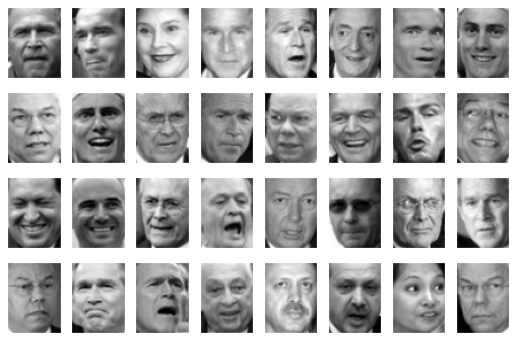

In [17]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]), figsize=(9, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

What we are looking for here is a low-dimensional embedding of this very high-dimensional data to learn the fundamental relationships between the images. We can start by computing a PCA and examining the explained variance ratio, which will give us an idea of how many linear features are required to describe the data:

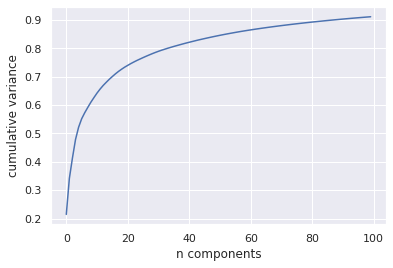

In [18]:
from sklearn.decomposition import PCA
model = PCA(100, svd_solver='randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

For this data, nearly 100 components are required in order to preserve about 90% of the variance, which indicates that this data can't be described nearly with just a few components.

For situations such as this, nonlinear manifold embedding like LLE and Isomap can be helpful. Let's compute an Isomap embedding on these faces:

In [19]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

We can get a better of what the projection tells us using the following function, which outputs image thumbnails at the locations of the projections:

In [20]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

We can now call this function and take a look at the result:

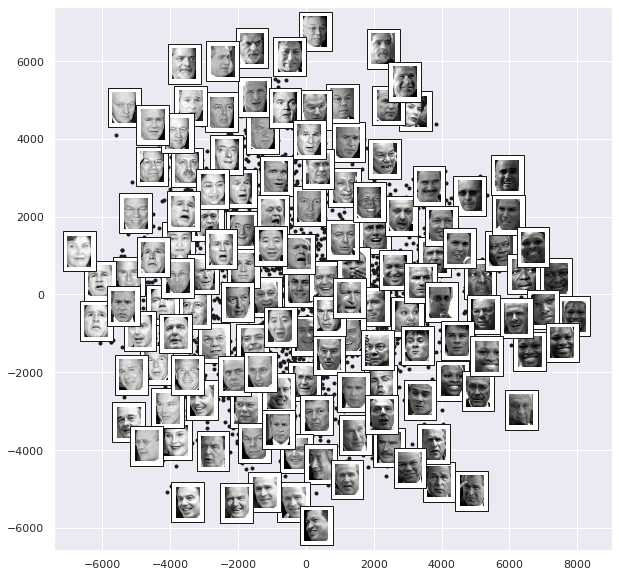

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

We can see that the first two Isomap dimensions seem to describe global image features: the overal darkness of the image from left to right, and the orientation of the faces from bottom to top.

## Example: Visualizing Structure in Digits

As another example of manifold learning for visualization, let's work with the MNIST handwritten digits set:

In [22]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.data.shape

(70000, 784)

This consists of 70000 images, each of 784 pixels (the images are 28$\times$28). Let's take a look at a few of them:

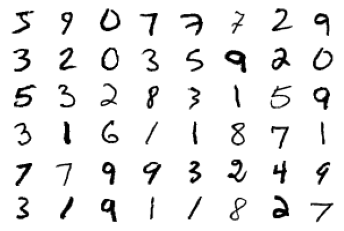

In [23]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

We will compute a manifold learning projection across 1/30 of the data for speed. Because of the high computational cost that is generally attached to manifold learning algorithms, this is generally a good strategy for quick exploration before moving to a full calculation.

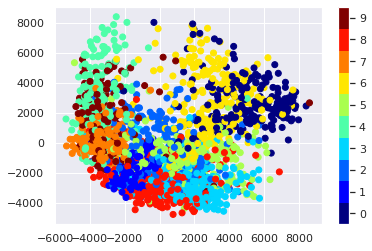

In [24]:
# use only 1/30 of the data: full dataset takes a long time!
data = mnist.data[::30]
target = list(map(int, mnist.target[::30]))

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

The resulting scatter plot shows some of the relationships between the data points, but is a bit crowded. Let's instead take a look at just a single number at a time:

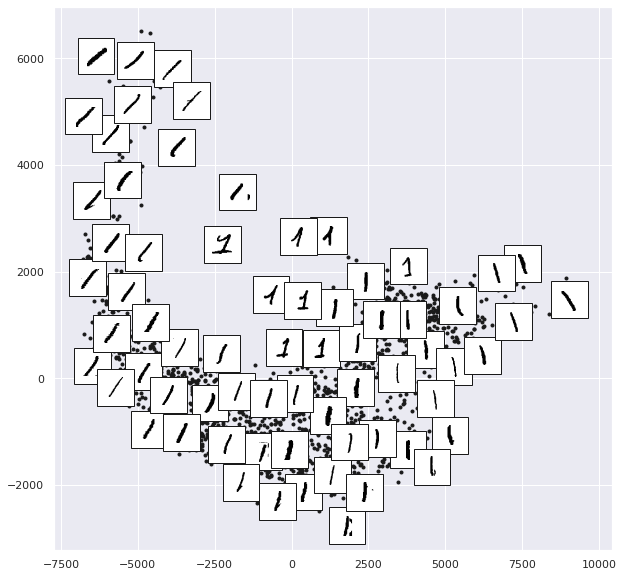

In [25]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == '1'][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

With this we can get an idea of the variety of forms that the number "1" can take within the dataset. The data lies along a curve in the projected space, which seems to indicate the orientation of the digit. At the top of the plot, we can find ones that have hats and/or bases, though these are rare occurrences. 

This kind of visualization is very insightful and can certainly help us get an understanding of the data, and may even give us ideas about how to move forward, such as how we might want to preprocess the data.